In [7]:
import pandas as pd
import os
import nltk
from collections import Counter
from sklearn.metrics import f1_score as f1
import re

input_path = '../../data/raw_data/finecite/'
ouput_path = './output'
os.makedirs(ouput_path, exist_ok=True)

df = pd.read_csv(os.path.join(input_path, 'full_data.csv'))
for col in ['iaa_macro', 'iaa_total', 'iaa_inf', 'iaa_perc','iaa_back']:
    df.fillna({col: 1}, inplace=True)
df.columns

Index(['id', 'citing_title', 'citing_pub_year', 'citing_authors',
       'cited_title', 'cited_pub_year', 'cited_authors', 'citation_type',
       'paragraph', 'target_reference_location', 'context_location1',
       'context_location2', 'iaa_macro', 'iaa_total', 'iaa_inf', 'iaa_perc',
       'iaa_back', 'guideline_version'],
      dtype='object')

In [8]:
# sentences in annotated span + not annotateted tokens in that span
num_sent_in_span = []
num_ann_sent = []
prop_not_annotated = []

# scope proportions
total_token_count = 0
inf_token_count = 0
perc_token_count = 0
backg_token_count = 0

# error sentence level context
sent_seg_majo_macro_f1 = []
sent_seg_prio_macro_f1 = []
sent_total_f1 = []

# error contiguous context
contiguous_macro_f1 = []
contiguous_total_f1 =[]

#fixed sized error
one_sent_fixed_majo_macro = []
one_sent_fixed_prio_macro = []
one_sent_fixed_total = []
two_sents_fixed_majo_macro = []
two_sents_fixed_prio_macro = []
two_sents_fixed_total = []
four_sents_fixed_majo_macro = []
four_sents_fixed_prio_macro = []
four_sents_fixed_total = []

# calculate avg. inter annotation scores
guideline_version = 1.1
macro_f1 = []
total_f1 = []
inf_f1 = []
perc_f1 = []
backg_f1 = []

#helpers

def eval_context(context: str|list, token_legth:int):
    res = eval(context)
    assert len(res) == token_legth, f'The context was {len(res)-token_legth} labels longer than the tokens'
    return res

def return_f1_of_custom_context(context:list, restraint: list, replacement = lambda x: 1, type:str = None):
    custom_context = [0 if i not in restraint else replacement(i) for i in range(len(context))]
    if type == 'macro':
        res = f1(context, custom_context, average='macro')
    else:
        res = f1(context, custom_context)
    return res

def return_contiguous_context_token_ids(target_citation_loc, context):
    res = [target_citation_loc]
    prev = target_citation_loc -1
    next = target_citation_loc + 1
    while prev >= 0:
        if context[prev] == 0:
            break
        res.insert(0, prev)
        prev -= 1
    while next < len(context):
        if context[next] == 0:
            break
        res.append(next)
        next += 1
    return res

def return_fixed_size_context_token_ids(target_sent_id: int, sent_id_to_token_id, amount:int = 1):
    if amount == 1: return sent_id_to_token_id[target_sent_id]
    selected_sentences = [target_sent_id]
    while len(selected_sentences) < amount:
        if len(selected_sentences) == len(sent_id_to_token_id): break
        prev = min(selected_sentences) - 1
        next = max(selected_sentences) + 1
        if prev in sent_id_to_token_id and next not in sent_id_to_token_id:
            selected_sentences.insert(0, prev)
        elif prev not in sent_id_to_token_id and next in sent_id_to_token_id:
            selected_sentences.append(next)
        else: 
            nr_prev = target_sent_id - prev
            nr_next = next - target_sent_id
            if nr_prev < nr_next:
                selected_sentences.insert(0, prev)
            else:
                selected_sentences.append(next)
    res = [id for sent_id in selected_sentences for id in sent_id_to_token_id[sent_id]]
    return res

##########################################################################

for i in range(len(df)):
    #set variables
    target_citation_loc = df.loc[i, 'target_reference_location']
    token_string = df.loc[i, 'paragraph'].replace(' ','')
    token_list = re.sub(r'<ref[^\>]+>[^\<]+<\/ref>','#AUTHOR_TAG', token_string).split(';')
    #token_list = re.findall(r'<ref[^\>]+>[^\<]+<\/ref>|[^;]+', token_string)
    contexts = [eval_context(df.loc[i, 'context_location1'], len(token_list))]
    if type(df.loc[i, 'context_location2']) != float:
        contexts.append(eval_context(df.loc[i, 'context_location2'], len(token_list)))
    
    #build token_id to sent_id, sent_id to token_id, token_id to context_label lookup
    token_id_to_sent_id = {}
    sent_id_to_token_id = {}
    token_id = 0
    sent_list = nltk.sent_tokenize(' '.join(token_list))
    sent_token_list = []
    for sent_id, sent in enumerate(sent_list):
        sent_id_to_token_id[sent_id] = []
        sent_token = sent.split(' ')
        sent_token_list.extend(sent_token)
        for token in sent_token:
            token_id_to_sent_id[token_id] = sent_id
            sent_id_to_token_id[sent_id].append(token_id)
            token_id += 1
    # assert whether token_ids span the same length as the token_list
    # print(token_list)
    # print(sent_token_list)
    if token_id != len(token_list):
        print('There is a mismatch between token id and token list length')
        continue
    
    if len(contexts) == 2:
        # if df.loc[i, 'guideline_version'] != guideline_version: continue
        macro_f1.append(f1(contexts[0],contexts[1], average='macro', zero_division=1))
        total_f1.append(f1([0 if label==0 else 1 for label in contexts[0]], [0 if label==0 else 1 for label in contexts[1]], zero_division=1))
        inf_f1.append(f1([0 if label!=1 else 1 for label in contexts[0]], [0 if label!=1 else 1 for label in contexts[1]], zero_division=1))
        perc_f1.append(f1([0 if label!=2 else 1 for label in contexts[0]], [0 if label!=2 else 1 for label in contexts[1]], zero_division=1))
        backg_f1.append(f1([0 if label!=3 else 1 for label in contexts[0]], [0 if label!=3 else 1 for label in contexts[1]], zero_division=1))
        
    for context in contexts:
        if not any(context): continue
        #fix target-reference not annotated
        if context[target_citation_loc] == 0:
            context[target_citation_loc] = context[target_citation_loc-1] if context[target_citation_loc-1] != 0 else 1
        context_no_scopes = [0 if label==0 else 1 for label in context]
        
        #select context, context sentences, calculate majority and priority tokens
        context_sent_token = []
        sent_id_to_majority_token = {}
        sent_id_to_priority_token = {}
        first_context_index = next((i for i, x in enumerate(context) if x != 0), None)
        last_context_index = next((i for i, x in enumerate(reversed(context)) if x != 0), None)
        context_span = context[first_context_index: -last_context_index-1]
        context_sentences = set([token_id_to_sent_id[token_id] for token_id, label in enumerate(context_span, start=first_context_index)if label != 0])
        
        for sent_id in context_sentences:
            sent_token_ids = sent_id_to_token_id[sent_id]
            sent_labels = [context[id] for id in sent_token_ids]
            context_sent_token.extend(sent_token_ids)
            
            #majority and priority token
            sent_id_to_majority_token[sent_id] = next(max_count[0] for max_count in Counter(sent_labels).most_common() if max_count[0] != 0)
            sent_id_to_priority_token[sent_id] = min([label for label in sent_labels if label != 0])
            
        #assert existing majority and priority token for each sentence
        assert len(sent_id_to_majority_token) == len(context_sentences) and len(sent_id_to_priority_token) == len(context_sentences), 'There is a mismatch of the majority token legth or the priority token length and the number of context sentences'  
        context_span_sent_token = context[min(context_sent_token): max(context_sent_token)+1]
        
        
        
        # calculate sentences in annotated span + not annotateted tokens in that span
        num_sent_in_span.append(1 + max(context_sentences) - min(context_sentences))
        num_ann_sent.append(len(context_sentences)) 
        prop_not_annotated.append(context_span_sent_token.count(0) / len(context_span_sent_token))
        
        # count token ocurances for scope proportions
        total_token_count += len([label for label in context if label != 0])
        inf_token_count += context.count(1)
        perc_token_count += context.count(2)
        backg_token_count += context.count(3)
        
        #calculate sentence level error
        sent_seg_majo_macro_f1.append(return_f1_of_custom_context(context, context_sent_token, lambda x: sent_id_to_majority_token[token_id_to_sent_id[x]], 'macro'))
        sent_seg_prio_macro_f1.append(return_f1_of_custom_context(context, context_sent_token, lambda x: sent_id_to_priority_token[token_id_to_sent_id[x]], 'macro'))
        sent_total_f1.append(return_f1_of_custom_context(context_no_scopes, context_sent_token))
        
        #calculate contiguous context error
        contiguous_macro_f1.append(return_f1_of_custom_context(context, return_contiguous_context_token_ids(target_citation_loc, context), lambda x: context[x], 'macro'))
        contiguous_total_f1.append(return_f1_of_custom_context(context_no_scopes, return_contiguous_context_token_ids(target_citation_loc, context)))
        
        #calculate fixed size context error
        target_sent_id = token_id_to_sent_id[target_citation_loc]
        one_sent_fixed_majo_macro.append(return_f1_of_custom_context(context, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id), lambda x: sent_id_to_majority_token[token_id_to_sent_id[x]] if token_id_to_sent_id[x] in sent_id_to_majority_token else 0,'macro'))
        one_sent_fixed_prio_macro.append(return_f1_of_custom_context(context, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id), lambda x: sent_id_to_priority_token[token_id_to_sent_id[x]] if token_id_to_sent_id[x] in sent_id_to_priority_token else 0 ,'macro'))
        one_sent_fixed_total.append(return_f1_of_custom_context(context_no_scopes, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id)))
        two_sents_fixed_majo_macro.append(return_f1_of_custom_context(context, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id, 2), lambda x: sent_id_to_majority_token[token_id_to_sent_id[x]] if token_id_to_sent_id[x] in sent_id_to_majority_token else 0 ,'macro'))
        two_sents_fixed_prio_macro.append(return_f1_of_custom_context(context, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id, 2), lambda x: sent_id_to_priority_token[token_id_to_sent_id[x]] if token_id_to_sent_id[x] in sent_id_to_priority_token else 0 ,'macro'))
        two_sents_fixed_total.append(return_f1_of_custom_context(context_no_scopes, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id, 2)))
        four_sents_fixed_majo_macro.append(return_f1_of_custom_context(context, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id, 4), lambda x: sent_id_to_majority_token[token_id_to_sent_id[x]] if token_id_to_sent_id[x] in sent_id_to_majority_token else 0 ,'macro'))
        four_sents_fixed_prio_macro.append(return_f1_of_custom_context(context, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id, 4), lambda x: sent_id_to_priority_token[token_id_to_sent_id[x]] if token_id_to_sent_id[x] in sent_id_to_priority_token else 0 ,'macro'))
        four_sents_fixed_total.append(return_f1_of_custom_context(context_no_scopes, return_fixed_size_context_token_ids(target_sent_id, sent_id_to_token_id, 4)))


with open(os.path.join(ouput_path, 'sample-statistics.txt'), 'w') as f_out:
        
    f_out.write(f'Avg. num of sentence in context span: {round(sum(num_sent_in_span)/len(num_sent_in_span), 3)}\nAvg. num of annotated sentences in context span: {round(sum(num_ann_sent)/len(num_ann_sent), 3)}\nAvg. proportion of not annotated_token in span: {round(sum(prop_not_annotated)/len(prop_not_annotated),3)}\n\n')

    f_out.write(f'Avg. proportion of information scope: {round(inf_token_count / total_token_count, 3)}\nAvg. proportion of perception scope: {round(perc_token_count / total_token_count, 3)}\nAvg. proportion of background scope: {round(backg_token_count / total_token_count, 3)}\n\n')

    f_out.write(f'Macro F1: {round(sum(macro_f1)/len(macro_f1), 3)}\nTotal F1: {round(sum(total_f1)/len(total_f1), 3)}\nInformation Scope F1: {round(sum(inf_f1)/len(inf_f1), 3)}\nPerception Scope F1: {round(sum(perc_f1)/len(perc_f1), 3)}\nBackground Scope F1: {round(sum(backg_f1)/len(backg_f1), 3)}\n\n')
    
    f_out.write(f'Sentence level error (majority token, macro F1): {round(sum(sent_seg_majo_macro_f1)/len(sent_seg_majo_macro_f1), 3)}\nSentence level error (priority token, macro F1): {round(sum(sent_seg_prio_macro_f1)/len(sent_seg_prio_macro_f1), 3)}\nSentence level error (total F1): {round(sum(sent_total_f1)/len(sent_total_f1), 3)}\n\n')

    f_out.write(f'Contiguous context error (macro F1): {round(sum(contiguous_macro_f1)/len(contiguous_macro_f1), 3)}\nContiguous context error (total F1): {round(sum(contiguous_total_f1)/len(contiguous_total_f1), 3)}\n\n')

    f_out.write(f'One Sentence:\n\tMacro F1 (majority label): {round(sum(one_sent_fixed_majo_macro)/len(one_sent_fixed_majo_macro), 3)}\n\tMacro F1 (priority label): {round(sum(one_sent_fixed_prio_macro)/len(one_sent_fixed_prio_macro), 3)}\n\tTotal F1: {round(sum(one_sent_fixed_total)/len(one_sent_fixed_total), 3)}\n')
    f_out.write(f'Two Sentences:\n\tMacro F1 (majority label): {round(sum(two_sents_fixed_majo_macro)/len(two_sents_fixed_majo_macro), 3)}\n\tMacro F1 (priority label): {round(sum(two_sents_fixed_prio_macro)/len(two_sents_fixed_prio_macro), 3)}\n\tTotal F1: {round(sum(two_sents_fixed_total)/len(two_sents_fixed_total), 3)}\n')
    f_out.write(f'Four Sentences:\n\tMacro F1 (majority label): {round(sum(four_sents_fixed_majo_macro)/len(four_sents_fixed_majo_macro), 3)}\n\tMacro F1 (priority label): {round(sum(four_sents_fixed_prio_macro)/len(four_sents_fixed_prio_macro), 3)}\n\tTotal F1: {round(sum(four_sents_fixed_total)/len(four_sents_fixed_total), 3)}')

       


There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length
There is a mismatch between token id and token list length


      context_length  information  perception  background
10                10     0.000000    1.000000    0.000000
49                10     1.000000    0.000000    0.000000
51                10     0.416667    0.000000    0.583333
61                10     0.166667    0.833333    0.000000
64                10     0.666667    0.333333    0.000000
...              ...          ...         ...         ...
1081              10     0.230769    0.769231    0.000000
1104              10     0.200000    0.800000    0.000000
1112              10     0.666667    0.333333    0.000000
1130              10     0.153846    0.846154    0.000000
1148              10     0.250000    0.000000    0.750000

[75 rows x 4 columns]


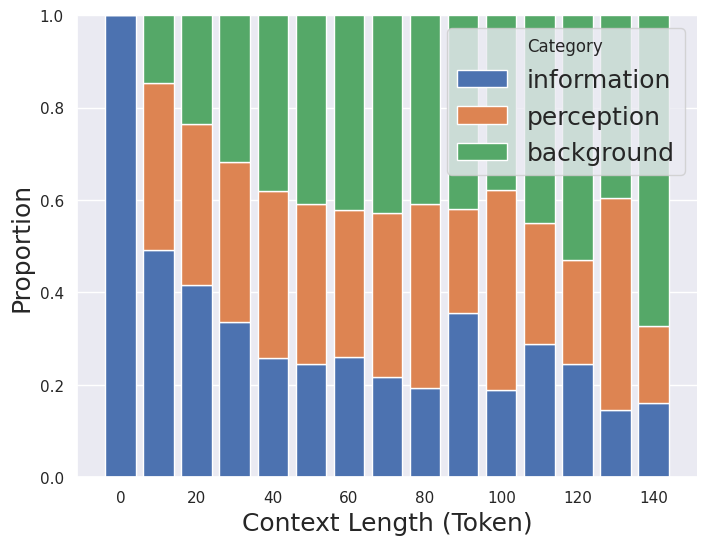

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def myround(x, base=10):
    return base * round(x/base)

contexts = []
for idx, row in df.iterrows():
    contexts.append([l for l in eval(row['context_location1']) if l != 0])
    if type(row['context_location2']) != float:
        contexts.append([l for l in eval(row['context_location2']) if l != 0])

# Convert to proportions for each context length

proportions = {'context_length': [], 'information': [], 'perception': [], 'background': []}

for context in contexts:
    length = len(context)
    info_count = sum([1 for l in context if l == 1])
    percep_count = sum([1 for l in context if l == 2])
    bg_count = sum([1 for l in context if l == 3])
    total = info_count + percep_count + bg_count
    assert total == length
    if total == 0: continue
    proportions['context_length'].append(myround(total))
    proportions['information'].append(info_count / total if total > 0 else 0)
    proportions['perception'].append(percep_count / total if total > 0 else 0)
    proportions['background'].append(bg_count / total if total > 0 else 0)

df_prop = pd.DataFrame(proportions)
df_prop = df_prop[df_prop['context_length']< 150]
df_agg = df_prop.groupby('context_length').mean().reset_index()
print(df_prop[df_prop['context_length']< 15])

# Create the plot with a 4:3 aspect ratio
fig, ax = plt.subplots(figsize=(8, 6))  # 4:3 aspect ratio

# Define the bottom of each bar
bottom = pd.Series([0] * len(df_agg))

# Plot each category with wider bars
bar_width = 8  # Adjust the width of the bars
for i, col in enumerate(df_agg.columns[1:]):
    ax.bar(df_agg['context_length'], df_agg[col], bottom=bottom, label=col, width=bar_width)
    bottom += df_agg[col]

# Add labels and title
ax.set_xlabel('Context Length (Token)', size=18)
ax.set_ylabel('Proportion', size=18)
ax.legend(title='Category', loc='upper right', prop={'size': 18})

# Improve the style to look like the provided plot
sns.set_theme(style='darkgrid')
sns.color_palette("pastel")
sns.despine()

plt.show()


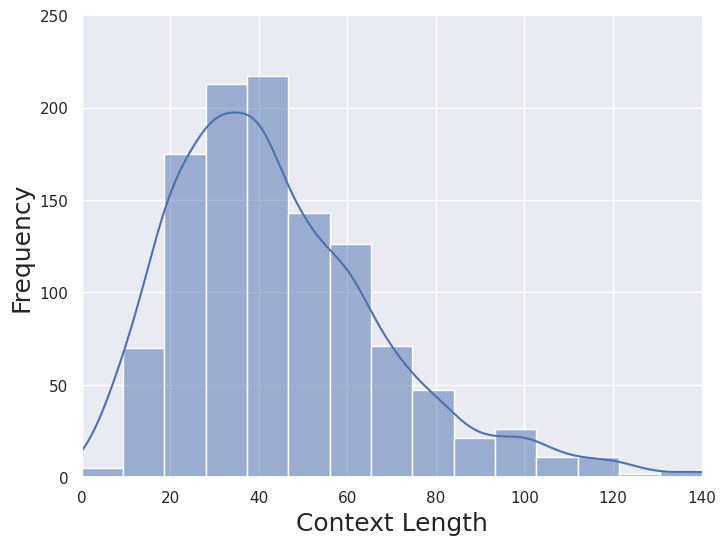

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution using seaborn and matplotlib
plt.figure(figsize=(8, 6))  # 4:3 aspect ratio
sns.histplot(df_prop['context_length'], bins=15, kde=True)
plt.xlabel('Context Length', size=18)
plt.ylabel('Frequency', size=18)
plt.xlim(0, 140)
plt.ylim(0, 250)


# Improve the style to look like the provided plot
sns.set_theme(style='darkgrid')
sns.color_palette("pastel")
sns.despine()

plt.show()



In [11]:
df_prop

,context_length,information,perception,background
0,40,0.500000,0.000000,0.500000
1,60,0.381818,0.309091,0.309091
2,40,0.128205,0.743590,0.128205
3,60,0.245902,0.491803,0.262295
4,20,1.000000,0.000000,0.000000
...,...,...,...,...
1147,20,0.823529,0.000000,0.176471
1148,10,0.250000,0.000000,0.750000
1149,40,0.136364,0.454545,0.409091
1150,40,0.268293,0.000000,0.731707
